In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 29.1 MB/s eta 0:00:00


In [ ]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

np.set_printoptions(precision=3, suppress=True)




In [ ]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "drive/MyDrive/EAI-2223-40" 

/content/drive/MyDrive/EAI_Project


In [ ]:
num_slices = 100 
start_slice = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
 

areas = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}
# days start interval
survival_categories= {
    'SHORT' : 0 , # 0-300
    'MEDIUM' : 300,  # 300-450
    'LONG' : 450, # 450 and more
}


In [ ]:
# Get a list of directories with studies, excluding one with ill-formatted name
train_and_val_directories = []
for f in os.scandir(TRAIN_DATASET_PATH):
    if f.is_dir() and os.path.basename(f.path) != 'BraTS20_Training_355':
        train_and_val_directories.append(f.path)

# Convert directory paths to study IDs
train_and_test_ids = [os.path.basename(path) for path in train_and_val_directories]


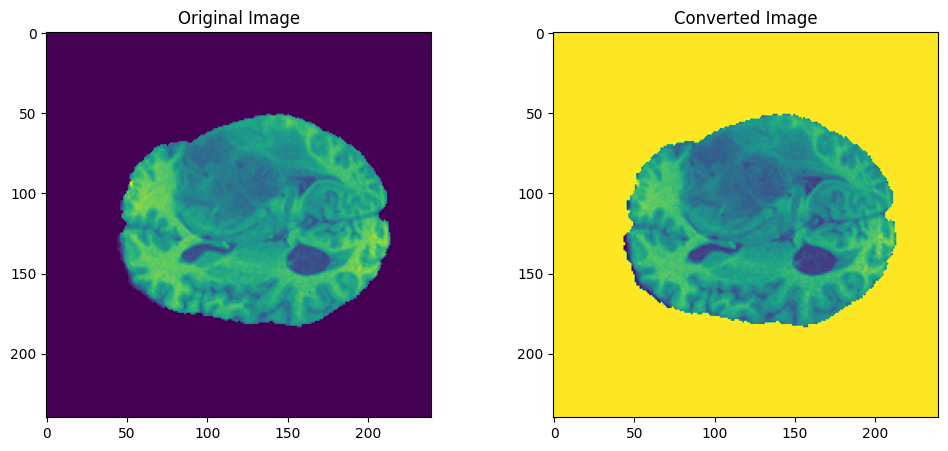

In [ ]:
# Load image volume
image_volume = nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

# Select a slice to display
my_loc_slice = 73
my_img = image_volume[:, :, my_loc_slice]

# Convert background pixels to a different color
my_converted_img = np.where(my_img == 0, 666, my_img)

# Plot the images side by side
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Plot original image
axs[0].imshow(my_img)
axs[0].set_title('Original Image')

# Plot converted image
axs[1].imshow(my_converted_img)
axs[1].set_title('Converted Image')

plt.show()

count class 1: 287
{1: 15443, 2: 168794, 3: 0}


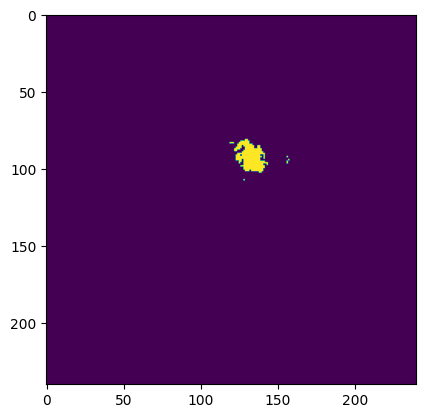

In [ ]:
my_loc_slice = 73
my_loc_class = 1

# Load segmentation data
seg_data = nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# Compute segmentation mask for the given slice and class
seg_mask = (seg_data[:, :, my_loc_slice] == my_loc_class)

# Compute total number of voxels for each class in the entire volume
seg_totals = dict([(1, 0), (2, 0), (3, 0)])
for i in range(1, 4):
    seg_totals[i] = np.count_nonzero(seg_data == i)

# Plot the segmentation mask for the given class
plt.imshow(seg_mask)

# Compute the number of voxels for the given class in the given slice
count = np.count_nonzero(seg_mask)
print(f'count class {my_loc_class}: {count}')
print(seg_totals)


In [ ]:
csv_path = 'survival_info.csv'

age_dict = {}
days_dict = {}

df = pd.read_csv(csv_path)
category_short = category_medium = category_long = 0
max_days = 0

for i, row in df.iterrows():
    if row[3] != "GTR":
        continue
    try:
        key = row[0]
        age = float(row[1])
        days = int(row[2])
    except ValueError:
        continue
    age_dict[key] = age
    days_dict[key] = days
    max_days = max(max_days, days)
    if days < 250:
        category_short += 1
    elif 250 <= days <= 450:
        category_medium += 1
    else:
        category_long += 1

print(f'Processed {df.shape[0]} lines.')
print(category_short, category_medium, category_long)
print(max_days)

Processed 236 lines.
34 38 46
1767


<ipython-input-16-f2ed66d64b4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'] = pd.to_numeric(df['Age'])
<ipython-input-16-f2ed66d64b4a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Survival_days'] = pd.to_numeric(df['Survival_days'])
<ipython-input-16-f2ed66d64b4a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

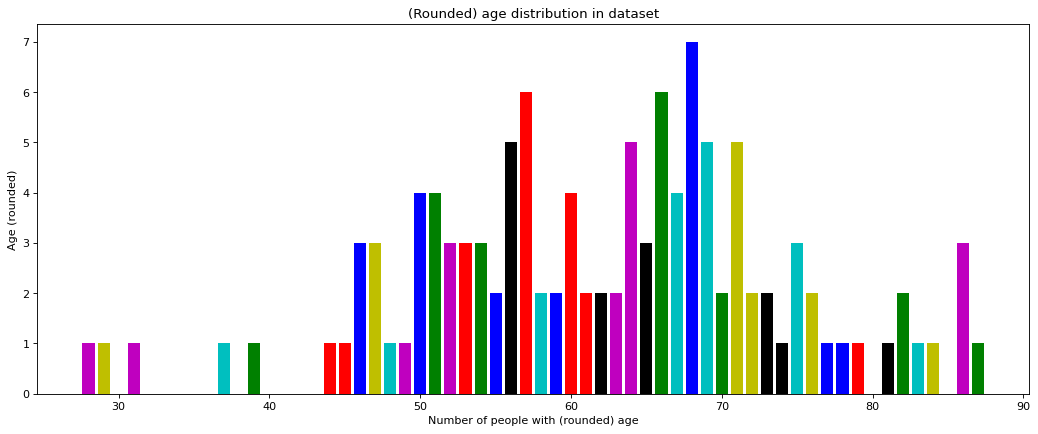

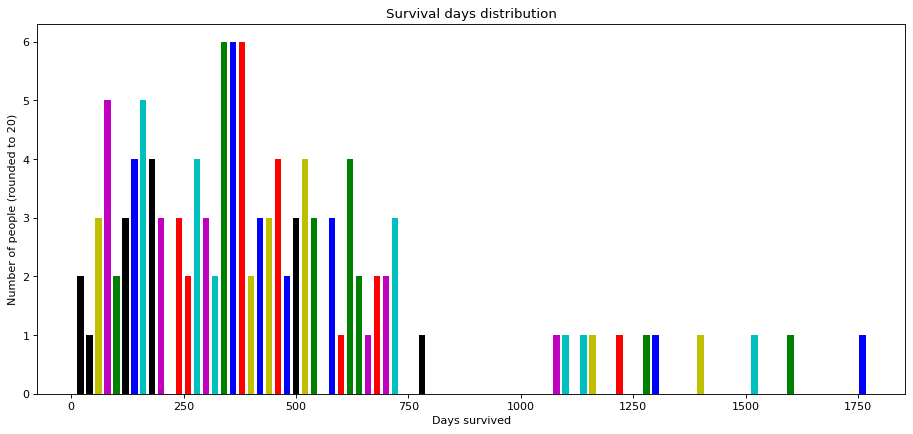

In [ ]:
# filter rows with GTR status and numeric days
df = df.loc[(df['Extent_of_Resection'] == 'GTR') & (df['Survival_days'].str.isnumeric())]

# convert age and days columns to numeric types
df['Age'] = pd.to_numeric(df['Age'])
df['Survival_days'] = pd.to_numeric(df['Survival_days'])

# round values in the DataFrame
df['age_rounded'] = df['Age'].round()
df['days_rounded'] = (df['Survival_days'] / 20).round() * 20

# count same numbers in the rounded age and days columns
age_counts = df['age_rounded'].value_counts()
days_counts = df['days_rounded'].value_counts()

# create color lists for the bar charts
colors_age = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors_days = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# create bar chart for rounded age distribution
plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age (rounded)')
plt.title("(Rounded) age distribution in dataset")
plt.bar(age_counts.index, age_counts.values, color=colors_age[:len(age_counts)])
plt.show()

# create bar chart for rounded survival days distribution
plt.figure(figsize=(14, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (rounded to 20)')
plt.title("Survival days distribution")
plt.bar(days_counts.index, days_counts.values, width=15, color=colors_days[:len(days_counts)])
plt.show()

In [ ]:
def getMaskSizesForVolume(image_volume):
    totals = {1: 0, 2: 0, 3: 0}
    for i in range(start_slice, start_slice + num_slices):
        arr = np.ravel(image_volume[:, :, i]) #same work as flatten 
        arr[arr == 4] = 3
        for k in range(1, 4):
            totals[k] += np.count_nonzero(arr == k)
    return totals


# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    flattened_volume = image_volume[:,:,start_slice:start_slice+num_slices].flatten()
    return np.count_nonzero(flattened_volume)

example=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example[:,:,start_slice])
axarr[1].imshow(example[:,:,start_slice+30])

print(f'total count: {getBrainSizeForVolume(example)}')

In [ ]:

# This function takes a list of patient IDs and returns two arrays
# One array (x_val) contains data for each patient - age and normalized count of each brain segment (1, 2, 3)
# Another array (y_val) contains the classification of each patient into one of three categories: short-term, medium-term, or long-term
def getListAgeDays(id_list):
    x_val = [] # initialize empty array to store patient data
    y_val = [] # initialize empty array to store patient classifications
    for i in id_list:
        age = age_dict.get(i)
        if age is None: # skip patients with missing age data
            continue
        
        # set paths for segmentation and t1 files for current patient
        seg_path = TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii'
        t1_path = TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii'
        
        # calculate normalized count of each brain segment (1, 2, 3) for the current patient
        masks = getMaskSizesForVolume(nib.load(seg_path).get_fdata())
        img=nib.load(t1_path).get_fdata()
        brain_vol = getBrainSizeForVolume(img)
        masks[1] = masks[1]/brain_vol
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol 
        merged=[age_dict[i],masks[1],masks[2],masks[3]]# normalize segment counts by brain volume
        #merged = [age] + masks # combine age and segment count data into a single list
        x_val.append(merged) 
        
        # classify the current patient as short-term, medium-term, or long-term based on their age in days
        if days_dict[i] < 250:
            y_val.append([1, 0, 0]) # short-term
        elif days_dict[i] < 450:
            y_val.append([0, 1, 0]) # medium-term
        else:
            y_val.append([0, 0, 1]) # long-term
            
    return np.array(x_val), np.array(y_val)

# generate data arrays for all patients in the train and test sets
X_all, y_all = getListAgeDays(train_and_test_ids)

# display the shape of the X_all array and a sample of the resulting dataframe
print(f'X_test: {X_all.shape}')
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1), 
                  columns=["age"] + [f"{areas[i]}" for i in range(1, 4)] + ["short", "medium", "long"])
df.head()

X_test: (118, 4)


,age,NECROTIC/CORE,EDEMA,ENHANCING,short,medium,long
0,50.0,0.014670,0.040742,0.048215,0.0,0.0,1.0
1,50.0,0.011305,0.088313,0.021569,1.0,0.0,0.0
2,49.0,0.001056,0.051954,0.013218,0.0,1.0,0.0
3,72.0,0.003969,0.022873,0.020015,0.0,0.0,1.0
4,57.0,0.018786,0.039295,0.036602,1.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age normalised",f"{areas[1]}",f"{areas[2]}",f"{areas[3]}"])
display(df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (94, 4)
x_test shape: (94, 4)
y_train shape: (94, 3)
y_test shape: (24, 3)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=3, random_state=0)

# fit the model to the training set
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy score with 3 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))



accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",rfc.score(X_test,y_test))


Model accuracy score with 3 decision-trees : 0.5417
Cross validation: Train Score: 0.3706317204301075
Cross validation: Test Score: 0.5416666666666666


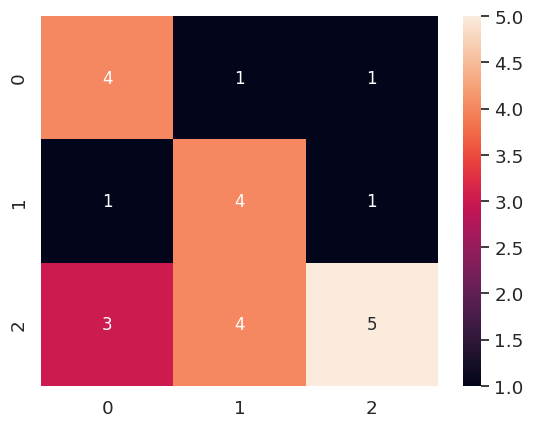

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.44      0.67      0.53         6
           2       0.71      0.42      0.53        12

   micro avg       0.59      0.54      0.57        24
   macro avg       0.61      0.58      0.58        24
weighted avg       0.63      0.54      0.56        24
 samples avg       0.54      0.54      0.54        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import shap
from shap import TreeExplainer
from shap import summary_plot

In [ ]:
explainer = TreeExplainer(rfc)
shap_values = np.array(explainer.shap_values(X_test))
print(shap_values.shape)


(6, 24, 4)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


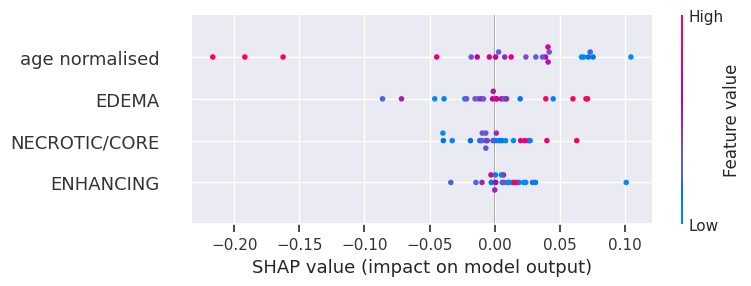

In [ ]:
shap.initjs()
summary_plot(shap_values[0],X_test,feature_names=["age normalised",	"NECROTIC/CORE",	"EDEMA",	"ENHANCING"])


In [ ]:
df = pd.DataFrame(X_train, columns = ["age",f"{areas[1]}",f"{areas[2]}",f"{areas[3]}"])

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores


age              0.320638
EDEMA            0.295156
ENHANCING        0.220772
NECROTIC/CORE    0.163435
dtype: float64

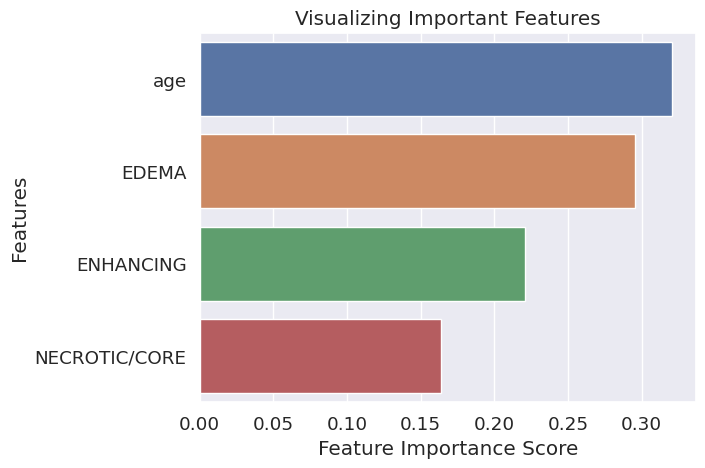

In [ ]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
from sklearn.svm import SVC

#convert one hot into multilabel
y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(random_state = 42, C=10, degree=3, gamma=1, kernel='poly')
svc.fit(X_train,y_train_multi)
accuracies = cross_val_score(svc, X_train, y_train_multi)


y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",svc.score(X_test,y_test_multi))


Model accuracy score : 0.4583
Cross validation: Train Score: 0.4900584795321638
Cross validation: Test Score: 0.4583333333333333


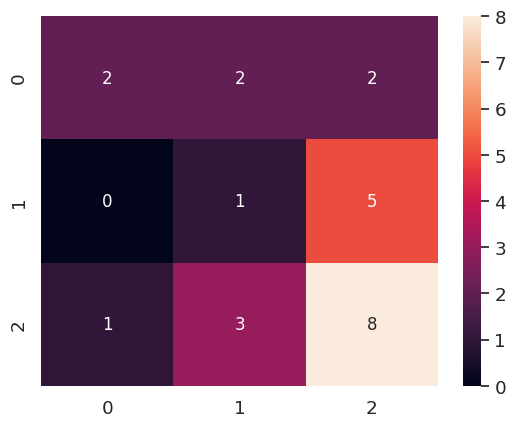

In [ ]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [ ]:
print(classification_report(y_test_multi, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.17      0.17      0.17         6
           2       0.53      0.67      0.59        12

    accuracy                           0.46        24
   macro avg       0.46      0.39      0.40        24
weighted avg       0.48      0.46      0.45        24



In [ ]:
explainer = shap.KernelExplainer(svc.predict,X_test)
shap_values = np.array(explainer.shap_values(X_test))
print(shap_values.shape)


  0%|          | 0/24 [00:00<?, ?it/s]

(24, 4)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


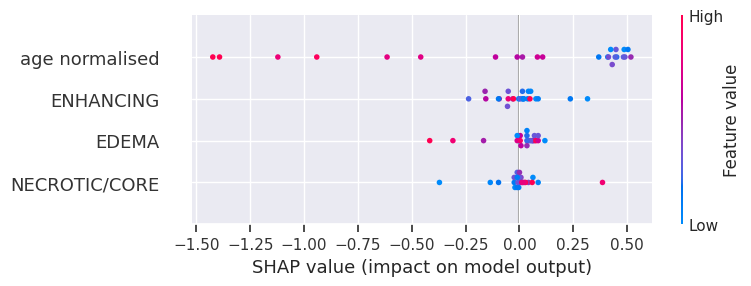

In [ ]:
shap.initjs()
summary_plot(shap_values,X_test,feature_names=["age normalised",	"NECROTIC/CORE",	"EDEMA",	"ENHANCING"])


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn  = KNeighborsClassifier(n_neighbors=10, p=3, weights='uniform')
knn.fit(X_train,y_train_multi)
accuracies = cross_val_score(knn, X_train, y_train_multi)

y_pred = knn.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",knn.score(X_test,y_test_multi))


Model accuracy score : 0.4167
Cross validation: Train Score: 0.4783625730994151
Cross validation: Test Score: 0.4166666666666667


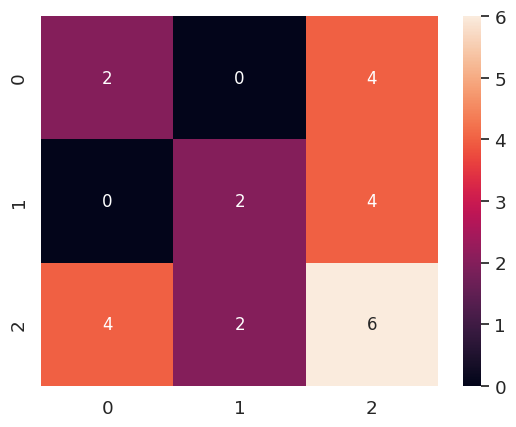

In [ ]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [ ]:
print(classification_report(y_test_multi, y_pred))


              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.50      0.33      0.40         6
           2       0.43      0.50      0.46        12

    accuracy                           0.42        24
   macro avg       0.42      0.39      0.40        24
weighted avg       0.42      0.42      0.41        24



  0%|          | 0/24 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


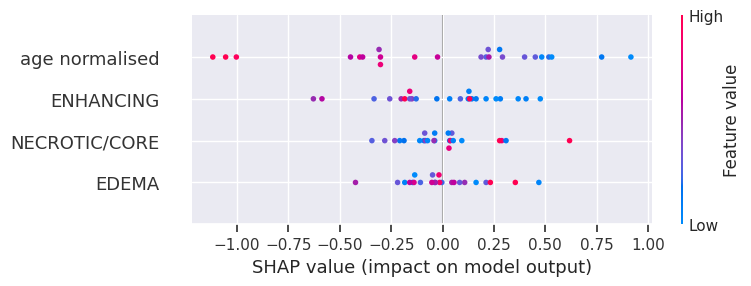

In [ ]:
knn.fit(X_train,y_train_multi)
knn_explainer = shap.KernelExplainer(knn.predict,X_test)
knn_shap_values = knn_explainer.shap_values(X_test)
shap.summary_plot(knn_shap_values, X_test,feature_names=["age normalised",	"NECROTIC/CORE",	"EDEMA",	"ENHANCING"])

In [ ]:
shap.initjs()
shap.force_plot(knn_explainer.expected_value, knn_shap_values, X_test)

In [ ]:
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(
    hidden_layer_sizes=20,
    max_iter=1000,
    alpha=1e-05,
    solver='lbfgs',
    verbose=10,
    random_state=6,
    
)

clf.fit(X_train, y_train_multi)
accuracies = cross_val_score(clf, X_train, y_train_multi)
y_pred = clf.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",clf.score(X_test,y_test_multi))


Model accuracy score : 0.5000
Cross validation: Train Score: 0.41578947368421043
Cross validation: Test Score: 0.5


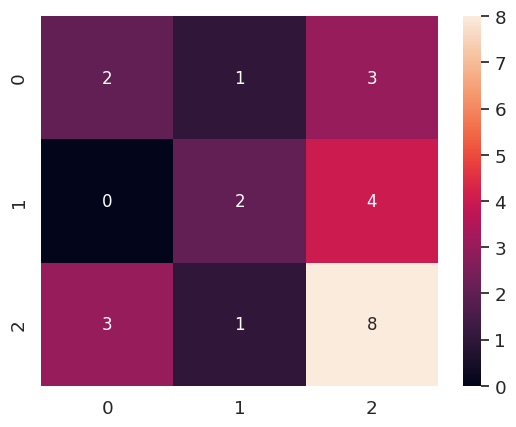

In [ ]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [ ]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.50      0.33      0.40         6
           2       0.53      0.67      0.59        12

    accuracy                           0.50        24
   macro avg       0.48      0.44      0.45        24
weighted avg       0.49      0.50      0.49        24



  0%|          | 0/24 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


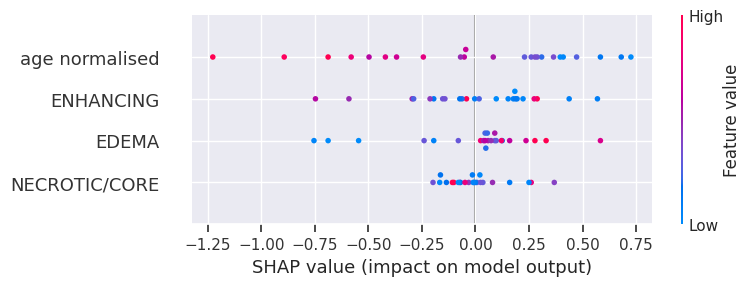

In [ ]:
clf_explainer = shap.KernelExplainer(clf.predict,X_test)
clf_values = clf_explainer.shap_values(X_test)
shap.summary_plot(clf_values, X_test,feature_names=["age normalised",	"NECROTIC/CORE",	"EDEMA",	"ENHANCING"])

In [ ]:
shap.initjs()
# plot the SHAP values for the 10th observation 
shap.force_plot(clf_explainer.expected_value,clf_values[10,:], X_test[10,:])